In [5]:
import pandas as pd
import csv
import xml.etree.ElementTree as ET
from pylabel import importer
import shutil
import glob
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import defaultdict
import numpy as np
import torch
import yaml
import streamlit as st
import cv2

In [ ]:
def read_class_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            # We split line and strip any whitespace
            parts = line.strip().split()
            if len(parts) == 2:
                image_id = parts[0]
                value = int(parts[1])
                data[image_id] = value
    return data

def combine_class_files(base_dir, split_type):
    combined_data = pd.DataFrame(columns=['Image'])
    
    pattern = os.path.join(base_dir, f'*_{split_type}.txt')
    class_files = glob.glob(pattern)
    
    if not class_files:
        print(f"No files found for pattern: {pattern}")
        return None
    for class_file in class_files:
        class_name = os.path.basename(class_file).split('_')[0]
        print(f"Processing {class_name} for {split_type}")
        
        class_data = read_class_file(class_file)
        
        if combined_data.empty:
            combined_data = pd.DataFrame(list(class_data.keys()), columns=['Image'])
        
        combined_data[class_name] = combined_data['Image'].map(class_data)
    
    return combined_data

base_dir = '/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/VOCdevkit/VOC2012/ImageSets/Main'

split_types = ['train', 'val', 'trainval']
output_dir = '/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset'
os.makedirs(output_dir, exist_ok=True)

for split_type in split_types:
    print(f"\nProcessing {split_type} split...")
    combined_df = combine_class_files(base_dir, split_type)
    
    if combined_df is not None:
        cols = ['Image'] + sorted([col for col in combined_df.columns if col != 'Image'])
        combined_df = combined_df[cols]
        

        output_path = os.path.join(output_dir, f'combined_{split_type}.csv')
        combined_df.to_csv(output_path, index=False)
        print(f"Saved combined {split_type} data to {output_path}")
        print(f"Shape: {combined_df.shape}")


Processing train split...
Processing train for train
Processing bus for train
Processing bottle for train
Processing motorbike for train
Processing aeroplane for train
Processing bird for train
Processing horse for train
Processing pottedplant for train
Processing sofa for train
Processing cow for train
Processing tvmonitor for train
Processing chair for train
Processing car for train
Processing dog for train
Processing bicycle for train
Processing diningtable for train
Processing boat for train
Processing person for train
Processing cat for train
Processing sheep for train
Saved combined train data to /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_train.csv
Shape: (5717, 21)

Processing val split...
Processing bottle for val
Processing cat for val
Processing dog for val
Processing sheep for val
Processing diningtable for val
Processing person for val
Processing bird for val
Processing car for val
Processing bicycle for val
Proce

In [ ]:
# Path to the directory containing your XML annotations and images
ANNOTATIONS_DIR = "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Annotations"
OUTPUT_DIR = "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/YOLOannotations"
CLASSES = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

def validate_and_fix_xml(xml_file):
    try:

        tree = ET.parse(xml_file)
        return tree
    except ET.ParseError as e:
        print(f"Fixing malformed XML: {xml_file}")

        with open(xml_file, 'r', encoding='utf-8') as file:
            content = file.read()

        content = content.replace('&', '&amp;')  

        with open(xml_file, 'w', encoding='utf-8') as file:
            file.write(content)

        try:
            tree = ET.parse(xml_file)
            return tree
        except ET.ParseError:
            print(f"Failed to fix XML: {xml_file}")
            return None
        
def parse_plain_text(file_path):
    yolo_annotations = []
    with open(file_path, "r") as f:
        lines = f.readlines()
    

    width = int(lines[6].strip())   
    height = int(lines[7].strip())  
    
    object_start = 12
    while object_start < len(lines):
        if lines[object_start].strip() == "":
            break 
        

        class_name = lines[object_start].strip()
        position = lines[object_start + 1].strip() 
        difficult = int(lines[object_start + 2].strip()) 
        truncated = int(lines[object_start + 3].strip()) 
        xmin = int(lines[object_start + 4].strip())
        ymin = int(lines[object_start + 5].strip())
        xmax = int(lines[object_start + 6].strip())
        ymax = int(lines[object_start + 7].strip())
        object_start += 8
        if class_name not in CLASSES:
            print(f"Warning: Class {class_name} not in predefined classes, skipping...")
            continue
        class_id = CLASSES.index(class_name)
        
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height
        
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")
    
    return yolo_annotations


def convert_annotation(xml_file):
    tree = validate_and_fix_xml(xml_file)
    if tree is None:
        return []
    
    root = tree.getroot()
    size = root.find("size")
    if size is None:
        print(f"Missing 'size' information in: {xml_file}")
        return []
    width = int(float(size.find("width").text))
    height = int(float(size.find("height").text))
    
    yolo_annotations = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        
        if class_name not in CLASSES:
            print(f"Skipping unknown class '{class_name}' in {xml_file}")
            continue
        
        class_id = CLASSES.index(class_name)
        bndbox = obj.find("bndbox")
        if bndbox is None:
            print(f"Missing 'bndbox' in object annotation in: {xml_file}")
            continue
        
        try:
            xmin = int(float(bndbox.find("xmin").text))
            ymin = int(float(bndbox.find("ymin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymax = int(float(bndbox.find("ymax").text))
        except ValueError as e:
            print(f"Invalid bounding box in {xml_file}: {e}")
            continue
        #We convert to YOLO format
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height
        
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")
    
    return yolo_annotations

for xml_file in os.listdir(ANNOTATIONS_DIR):
    if not xml_file.endswith(".xml") or xml_file.startswith("~$"):
        continue
    
    input_path = os.path.join(ANNOTATIONS_DIR, xml_file)
    yolo_annotations = convert_annotation(input_path)
    
    if not yolo_annotations:
        print(f"No valid annotations for: {xml_file}")
        continue
    output_file = os.path.join(OUTPUT_DIR, xml_file.replace(".xml", ".txt"))
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_annotations))

print("DONE!")




DONE!


In [ ]:

CSV_FILES = {
    "train": "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_train.csv",
    "val": "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_val.csv",
    "trainval": "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_trainval.csv",
}
YOLO_ANNOTATIONS_DIR = "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/YOLOannotations"

def remove_and_organize_annotations(csv_path, split_name):
    try:
        df = pd.read_csv(csv_path)
        print(f"\nProcessing {csv_path} for split '{split_name}'...")
        print(f"Initial entries in CSV: {len(df)}")

        split_dir = os.path.join(YOLO_ANNOTATIONS_DIR, split_name)
        os.makedirs(split_dir, exist_ok=True)
        valid_entries = []
        missing_annotations = []

        for image_name in df['Image']:
            annotation_file = os.path.join(YOLO_ANNOTATIONS_DIR, f"{image_name}.txt")
            
            if os.path.exists(annotation_file):
                try:
                    destination = os.path.join(split_dir, f"{image_name}.txt")
                    shutil.move(annotation_file, destination)
                    valid_entries.append(image_name)
                except (shutil.Error, OSError) as e:
                    print(f"Error moving annotation file for {image_name}: {e}")
                    missing_annotations.append(image_name)
            else:
                missing_annotations.append(image_name)
                print(f"Missing annotation: {annotation_file}")
        filtered_df = df[df['Image'].isin(valid_entries)].copy()
        removed_count = len(df) - len(filtered_df)
        
        print(f"Split '{split_name}' summary:")
        print(f"- Removed {removed_count} entries with missing annotations")
        print(f"- Remaining valid entries: {len(filtered_df)}")
        
        return filtered_df

    except Exception as e:
        print(f"Error processing {split_name} split: {e}")
        return pd.DataFrame()
print("Starting dataset organization process...")

for split_name, csv_path in CSV_FILES.items():
    if not os.path.exists(csv_path):
        print(f"CSV file not found: {csv_path}")
        continue
    filtered_df = remove_and_organize_annotations(csv_path, split_name)
    
    if not filtered_df.empty:
        try:
            filtered_df.to_csv(csv_path, index=False)
            print(f"Successfully updated {csv_path}")
        except Exception as e:
            print(f"Error saving updated CSV for {split_name}: {e}")

print("\nDataset organization complete!")

Starting dataset organization process...

Processing /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_train.csv for split 'train'...
Initial entries in CSV: 5717
Missing annotation: /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/YOLOannotations/2010_004144.txt
Missing annotation: /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/YOLOannotations/2010_004726.txt
Split 'train' summary:
- Removed 2 entries with missing annotations
- Remaining valid entries: 5715
Successfully updated /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_train.csv

Processing /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/Yolov8_Training_dataset/combined_val.csv for split 'val'...
Initial entries in CSV: 5823
Missing annotation: /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/YOLOannotations/2011_002802.txt
Split 'val' s

Analyzing training dataset...


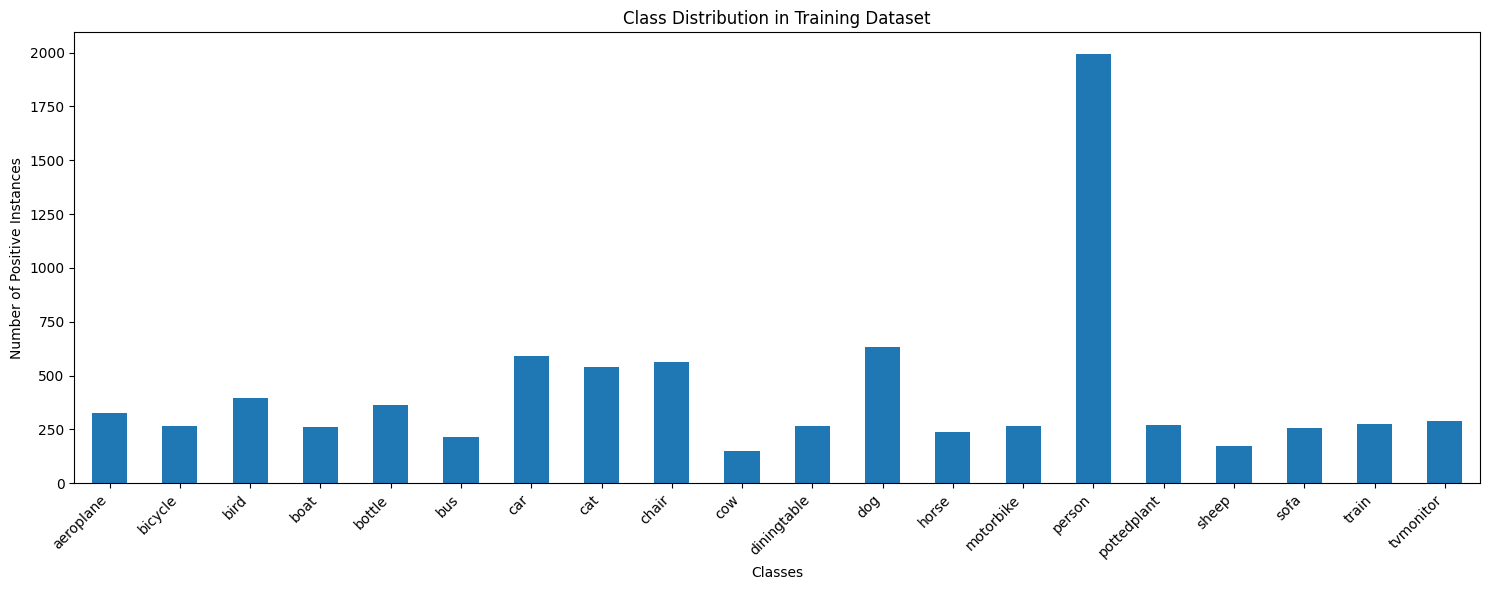


Class distribution in Training dataset:
aeroplane: 327 instances (5.72%)
bicycle: 268 instances (4.69%)
bird: 395 instances (6.91%)
boat: 260 instances (4.55%)
bottle: 365 instances (6.39%)
bus: 213 instances (3.73%)
car: 590 instances (10.32%)
cat: 538 instances (9.41%)
chair: 565 instances (9.89%)
cow: 151 instances (2.64%)
diningtable: 268 instances (4.69%)
dog: 632 instances (11.06%)
horse: 237 instances (4.15%)
motorbike: 265 instances (4.64%)
person: 1994 instances (34.89%)
pottedplant: 269 instances (4.71%)
sheep: 171 instances (2.99%)
sofa: 257 instances (4.50%)
train: 273 instances (4.78%)
tvmonitor: 290 instances (5.07%)

Analyzing validation dataset...


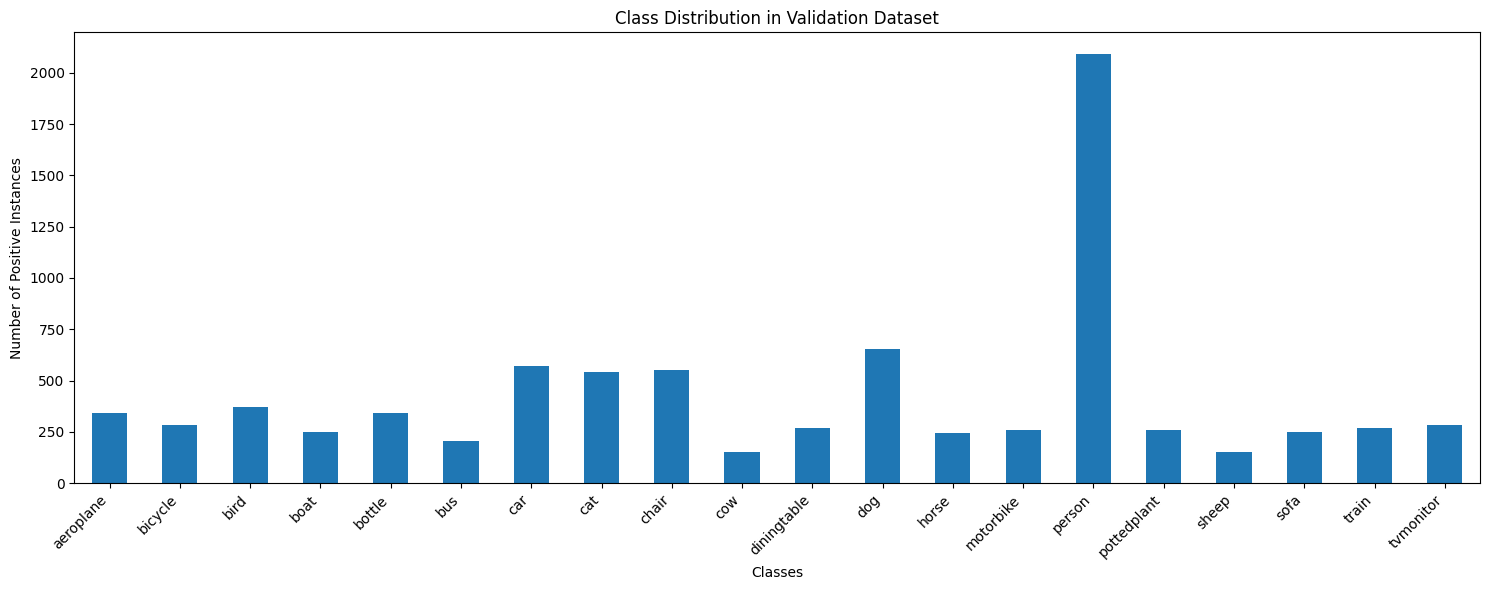


Class distribution in Validation dataset:
aeroplane: 343 instances (5.89%)
bicycle: 284 instances (4.88%)
bird: 370 instances (6.36%)
boat: 248 instances (4.26%)
bottle: 341 instances (5.86%)
bus: 208 instances (3.57%)
car: 571 instances (9.81%)
cat: 541 instances (9.29%)
chair: 553 instances (9.50%)
cow: 152 instances (2.61%)
diningtable: 269 instances (4.62%)
dog: 654 instances (11.23%)
horse: 245 instances (4.21%)
motorbike: 261 instances (4.48%)
person: 2092 instances (35.93%)
pottedplant: 258 instances (4.43%)
sheep: 154 instances (2.65%)
sofa: 250 instances (4.29%)
train: 271 instances (4.65%)
tvmonitor: 284 instances (4.88%)

Analyzing image sizes...


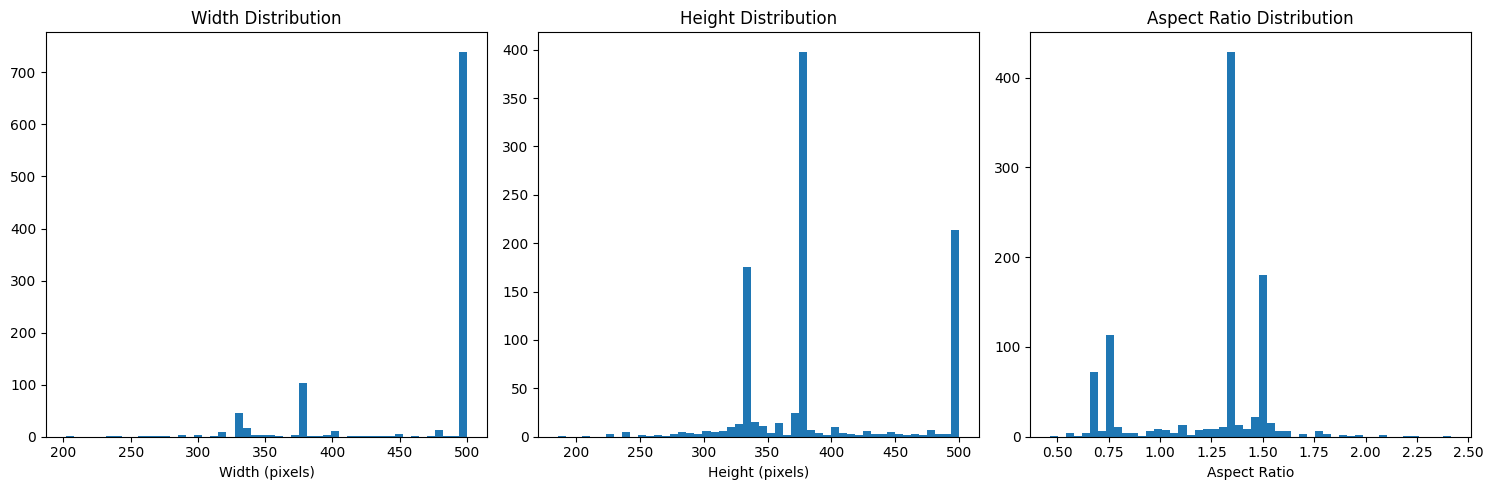


Image size statistics:
Width - Mean: 465.5, Std: 63.4
Height - Mean: 391.4, Std: 65.5
Aspect Ratio - Mean: 1.24, Std: 0.30

Analyzing bounding boxes...


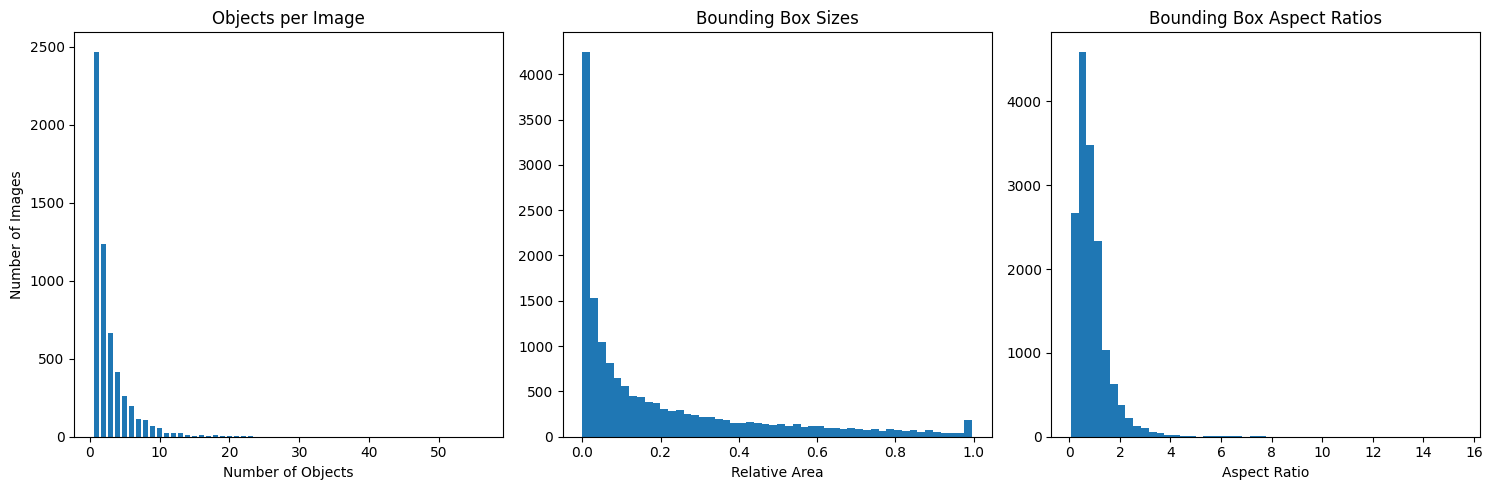


Bounding box statistics:
Average objects per image: 2.76
Box size - Mean: 0.200, Std: 0.249
Box aspect ratio - Mean: 0.89, Std: 0.68


In [ ]:
BASE_DIR = "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification"
IMAGES_DIR = '/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/JPEGImages'
LABELS_DIR = os.path.join(BASE_DIR, "YOLOannotations")
CSV_DIR = os.path.join(BASE_DIR, "Yolov8_Training_dataset")

train_df = pd.read_csv(os.path.join(CSV_DIR, 'combined_train.csv'))
val_df = pd.read_csv(os.path.join(CSV_DIR, 'combined_val.csv'))
trainval_df = pd.read_csv(os.path.join(CSV_DIR, 'combined_trainval.csv'))

def analyze_class_distribution(df, split_name):
    class_counts = (df.iloc[:, 1:] == 1).sum()
    
    plt.figure(figsize=(15, 6))
    class_counts.plot(kind='bar')
    plt.title(f'Class Distribution in {split_name} Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Positive Instances')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\nClass distribution in {split_name} dataset:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} instances ({(count/len(df)*100):.2f}%)")

def analyze_image_sizes():
    """Analyze the distribution of image sizes"""
    
    widths = []
    heights = []
    aspects = []
    image_files = os.listdir(IMAGES_DIR)
    if len(image_files) > 1000:
        image_files = np.random.choice(image_files, 1000, replace=False)
    
    for img_file in image_files:
        if img_file.endswith('.jpg'):
            img_path = os.path.join(IMAGES_DIR, img_file)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                    aspects.append(w/h)
            except Exception as e:
                print(f"Error processing {img_file}: {e}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.hist(widths, bins=50)
    ax1.set_title('Width Distribution')
    ax1.set_xlabel('Width (pixels)')
    
    ax2.hist(heights, bins=50)
    ax2.set_title('Height Distribution')
    ax2.set_xlabel('Height (pixels)')
    
    ax3.hist(aspects, bins=50)
    ax3.set_title('Aspect Ratio Distribution')
    ax3.set_xlabel('Aspect Ratio')
    
    plt.tight_layout()
    plt.show()
    
    print("\nImage size statistics:")
    print(f"Width - Mean: {np.mean(widths):.1f}, Std: {np.std(widths):.1f}")
    print(f"Height - Mean: {np.mean(heights):.1f}, Std: {np.std(heights):.1f}")
    print(f"Aspect Ratio - Mean: {np.mean(aspects):.2f}, Std: {np.std(aspects):.2f}")

def analyze_bounding_boxes(split='train'):
    """Analyze bounding box distributions"""
    
    boxes_per_image = defaultdict(int)
    box_sizes = []
    box_aspects = []
    
    label_dir = os.path.join(LABELS_DIR, split)
    
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                lines = f.readlines()
                boxes_per_image[len(lines)] += 1
                
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:  
                        width = float(parts[3])
                        height = float(parts[4])
                        box_sizes.append(width * height)
                        box_aspects.append(width / height)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.bar(boxes_per_image.keys(), boxes_per_image.values())
    ax1.set_title('Objects per Image')
    ax1.set_xlabel('Number of Objects')
    ax1.set_ylabel('Number of Images')
    
    ax2.hist(box_sizes, bins=50)
    ax2.set_title('Bounding Box Sizes')
    ax2.set_xlabel('Relative Area')
    
    ax3.hist(box_aspects, bins=50)
    ax3.set_title('Bounding Box Aspect Ratios')
    ax3.set_xlabel('Aspect Ratio')
    
    plt.tight_layout()
    plt.show()
    
    print("\nBounding box statistics:")
    print(f"Average objects per image: {sum(k*v for k,v in boxes_per_image.items()) / sum(boxes_per_image.values()):.2f}")
    print(f"Box size - Mean: {np.mean(box_sizes):.3f}, Std: {np.std(box_sizes):.3f}")
    print(f"Box aspect ratio - Mean: {np.mean(box_aspects):.2f}, Std: {np.std(box_aspects):.2f}")

print("Analyzing training dataset...")
analyze_class_distribution(train_df, 'Training')

print("\nAnalyzing validation dataset...")
analyze_class_distribution(val_df, 'Validation')

print("\nAnalyzing image sizes...")
analyze_image_sizes()

print("\nAnalyzing bounding boxes...")
analyze_bounding_boxes('train')

In [ ]:
BASE_DIR = "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification"
DATASET_DIR = os.path.join(BASE_DIR, "dataset")
IMAGES_DIR = os.path.join(BASE_DIR, "JPEGImages")
LABELS_DIR = os.path.join(BASE_DIR, "YOLOannotations")
CSV_DIR = os.path.join(BASE_DIR, "Yolov8_Training_dataset")
TEST_DIR = os.path.join(BASE_DIR, "Random_test_img")

for split in ['train', 'val']:
    os.makedirs(os.path.join(DATASET_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, split, 'labels'), exist_ok=True)

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

dataset_yaml = {
    'path': DATASET_DIR,
    'train': 'train/images',
    'val': 'val/images',
    'names': {i: name for i, name in enumerate(classes)},
    'nc': len(classes)
}

with open(os.path.join(BASE_DIR, 'dataset.yaml'), 'w') as f:
    yaml.dump(dataset_yaml, f, sort_keys=False)

print("Organizing dataset...")

for split in ['train', 'val']:
    csv_path = os.path.join(CSV_DIR, f'combined_{split}.csv')
    df = pd.read_csv(csv_path)
    
    for image_name in df['Image'].values:
        src_img = os.path.join(IMAGES_DIR, f"{image_name}.jpg")
        dst_img = os.path.join(DATASET_DIR, split, 'images', f"{image_name}.jpg")
        src_label = os.path.join(LABELS_DIR, split, f"{image_name}.txt")
        dst_label = os.path.join(DATASET_DIR, split, 'labels', f"{image_name}.txt")
        
        if os.path.exists(src_img) and os.path.exists(src_label):
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_label, dst_label)

print("Starting training...")

model = YOLO('yolov8n.pt')
results = model.train(
    data=os.path.join(BASE_DIR, 'dataset.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    workers=4,
    device='cpu',
    save=True,
    save_period=5,
    patience=10,
    verbose=True
)

metrics = model.val()
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"mAP50-95: {metrics.box.map:.3f}")


Organizing dataset...
Starting training...
Ultralytics 8.3.23 🚀 Python-3.12.4 torch-2.5.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/dataset.yaml, epochs=20, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=cpu, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

train: Scanning /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/dataset/train/labels.cache... 5715 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5715/5715 [00:00<?, ?it/s]
val: Scanning /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/dataset/val/labels.cache... 5821 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5821/5821 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.004      2.759      1.276         10        640: 100%|██████████| 358/358 [38:02<00:00,  6.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:40<00:00,  4.18s/it]


                   all       5821      15782      0.648      0.574      0.617      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.076      1.964      1.329         17        640: 100%|██████████| 358/358 [38:14<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:38<00:00,  4.17s/it]


                   all       5821      15782      0.651      0.556      0.596      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.099      1.915      1.348         20        640: 100%|██████████| 358/358 [38:16<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:46<00:00,  4.21s/it]


                   all       5821      15782      0.635      0.526      0.573      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.095      1.867      1.344         16        640: 100%|██████████| 358/358 [39:19<00:00,  6.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:59<00:00,  4.28s/it]


                   all       5821      15782      0.652      0.539      0.587      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.078       1.76      1.339         19        640: 100%|██████████| 358/358 [38:23<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:38<00:00,  4.17s/it]


                   all       5821      15782      0.648       0.54       0.59      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.068      1.678      1.327         17        640: 100%|██████████| 358/358 [38:24<00:00,  6.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:38<00:00,  4.17s/it]


                   all       5821      15782      0.659      0.556      0.609      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.048      1.611      1.313         16        640: 100%|██████████| 358/358 [38:48<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:57<00:00,  4.27s/it]


                   all       5821      15782      0.688      0.572      0.634      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G       1.02      1.529      1.297         10        640: 100%|██████████| 358/358 [39:06<00:00,  6.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:43<00:00,  4.19s/it]


                   all       5821      15782      0.706      0.571      0.633      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.9974      1.475      1.275         12        640: 100%|██████████| 358/358 [38:13<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:39<00:00,  4.17s/it]


                   all       5821      15782      0.703      0.607      0.662      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.9964      1.433       1.27         19        640: 100%|██████████| 358/358 [38:18<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:37<00:00,  4.16s/it]


                   all       5821      15782      0.719      0.592      0.664      0.466
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.9948      1.385      1.283         12        640: 100%|██████████| 358/358 [37:59<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:35<00:00,  4.15s/it]


                   all       5821      15782      0.728      0.599      0.674      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.9709      1.289       1.26         11        640: 100%|██████████| 358/358 [37:59<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:37<00:00,  4.16s/it]


                   all       5821      15782      0.754      0.598       0.68      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.9377      1.214      1.229          7        640: 100%|██████████| 358/358 [38:03<00:00,  6.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:35<00:00,  4.15s/it]


                   all       5821      15782      0.752      0.616      0.694      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.9176      1.151      1.217         15        640: 100%|██████████| 358/358 [37:55<00:00,  6.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:37<00:00,  4.16s/it]


                   all       5821      15782      0.747       0.63      0.696      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.8977      1.102      1.199          7        640: 100%|██████████| 358/358 [38:18<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:39<00:00,  4.17s/it]


                   all       5821      15782      0.739       0.64        0.7      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8817      1.069      1.189          3        640: 100%|██████████| 358/358 [38:12<00:00,  6.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:40<00:00,  4.18s/it]


                   all       5821      15782      0.757      0.633      0.706      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8691       1.03      1.175         13        640: 100%|██████████| 358/358 [37:59<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:37<00:00,  4.16s/it]


                   all       5821      15782      0.772      0.635      0.717      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.8532     0.9915      1.165         10        640: 100%|██████████| 358/358 [37:58<00:00,  6.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:36<00:00,  4.16s/it]


                   all       5821      15782      0.772      0.645      0.721      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.8325     0.9545      1.146         16        640: 100%|██████████| 358/358 [37:55<00:00,  6.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:36<00:00,  4.16s/it]


                   all       5821      15782      0.782      0.644      0.723      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.8179     0.9297       1.14          7        640: 100%|██████████| 358/358 [37:50<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [12:54<00:00,  4.26s/it]


                   all       5821      15782      0.789      0.644      0.728      0.532

20 epochs completed in 16.991 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.12.4 torch-2.5.0 CPU (Apple M1)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [11:47<00:00,  3.89s/it]


                   all       5821      15782      0.787      0.644      0.728      0.532
             aeroplane        348        484      0.895      0.694      0.796      0.612
               bicycle        290        380      0.815       0.66      0.758      0.577
                  bird        374        629      0.822      0.595        0.7      0.492
                  boat        252        491      0.719      0.468       0.57      0.335
                bottle        369        733      0.776      0.468      0.577      0.383
                   bus        211        320      0.891      0.763      0.827      0.682
                   car        608       1173      0.821       0.67      0.766      0.551
                   cat        544        618      0.814      0.805      0.857      0.666
                 chair        642       1449      0.698      0.482      0.583      0.397
                   cow        154        347       0.68      0.683       0.71      0.531
           diningtabl

val: Scanning /Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification/dataset/val/labels.cache... 5821 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5821/5821 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [14:25<00:00,  2.38s/it]


                   all       5821      15782      0.788      0.642      0.728      0.532
             aeroplane        348        484      0.896      0.692      0.796      0.612
               bicycle        290        380      0.814      0.658      0.758      0.577
                  bird        374        629      0.828      0.595      0.701      0.492
                  boat        252        491      0.717      0.465      0.571      0.336
                bottle        369        733      0.775      0.466      0.577      0.383
                   bus        211        320      0.897      0.761      0.826      0.682
                   car        608       1173      0.823      0.668      0.767       0.55
                   cat        544        618      0.813      0.804      0.857      0.666
                 chair        642       1449      0.699       0.48      0.583      0.397
                   cow        154        347      0.684      0.683       0.71      0.531
           diningtabl

TypeError: 'bool' object is not callable

In [ ]:
BASE_DIR = "/Users/estebanm/Desktop/QC_FALL_2024/cs325/Multi_Class Classification"
TEST_DIR = os.path.join(BASE_DIR, "Random_test_img")

# Load the trained model (use best.pt for best performance)
model = YOLO('runs/detect/train/weights/best.pt')

# Run predictions
results = model.predict(
    source=TEST_DIR,
    conf=0.25,
    save=True,
    show=True,
    show_labels=True,
    show_conf=True,
    line_width=2,
    boxes=True
)
print("Predictions complete! Check the 'runs/detect/predict' folder for results.")

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


KeyboardInterrupt: 

: 